<a href="https://colab.research.google.com/github/spencerau/CPSC392/blob/main/Homework/HW1/HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 1
Homeworks are an individual assessment, you

---

should not work in groups.

---



You will be turning in:

1. A [README.md](https://github.com/cmparlettpelleriti/CPSC392ParlettPelleriti/blob/master/Admin/READMEexample.md) with all the relevant information
2. An .ipynb with just your code (show all code necessary for the analysis, but remove superfluous code)
3. A PDF with your Report (rendered via Quarto)


## Data
We're going to be using some [clothing store data](https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/boutique.csv) to help the company predict how much their customers will spend with them per year.

- `gender`: self-disclosed gender identity, `male`, `female`, `nonbinary` or `other`
- `age`: current age of customer
- `height_cm`: self-reported height converted to centimeters
- `waist_size_cm`: self-reported waist size converted to centimeters
- `inseam_cm`: self-reported inseam (measurement from crotch of pants to floor) converted to centimeters
- `test_group`: whether or not the customer is in an experimental test group that gets special coupons once a month. `0` for no, `1` for yes.
- `salary_self_report_in_k`: self-reported salary of customer, in thousands
- `months_active`: number of months customer has been part of the clothing store's preferred rewards program
- `num_purchases`: the number of purchases the customer has made (a purchase is a single transaction that could include multiple items)
- `amount_spent_annual`: the average amount the customer has spent at the store per year


## 1. Modeling
- Drop Missing Values and Reset Indices if needed.
- Using *Train-Test-Split Model Validation* with an 80/20 split and `sklearn` `Pipeline`s, build **two** models that predict the average amount the customer spends in a year using all the other variables.
- Z-score continuous/interval variables, and One Hot Encode categorical variables (when needed) before fitting your models.
- Try both a typical **Linear Regression** model and a **Polynomial Regression** model (using `PolynomialFeatures()`)
- Once the model is trained, calculate the *MSE, MAE, MAPE, and $R^2$* for both the training and testing sets of both models.

## 2. Graphs
Choose 2 of the following questions to answer. Build at *least* one ggplot to answer each question (you can also do other calculations in addition), and write a detailed written answer based on the graph and calculations in your report (below). You do not NEED to use your model for these questions, they can be purely descriptive.

- Does being in the experimental `test_group` actually increase the amount a customer spends at the store? Is this relationship different for the different genders?
- Does making more money (salary) tend to increase the number of purchases someone makes? Does it increase the total amount spent?
- In which year did the store's *customers* make the most money? Were the store's sales highest in those years?
- People who are not your "average" size often find it difficult to buy clothes in traditional stores. Is there a relationship between inseam and amount spent in the store annually? Is there a relationship between height and amount spent in the store annually?
- In this dataset, is there a relationship between salary and height? Is it different for the different genders?
- The store is interested in whether their customer base has changed over time. Present the minimum, maximum, and average height, waist size, and inseam for each year.


For all ggplots, make sure you make changes so that the data viz is effective, clear, and does not contain distracting elements, graphs will be graded both on correctness (did you plot the right thing) as well as on effectiveness (does this graph thoughtfully demonstrate the principles we learned in our data viz lectures).

## 3. Report

[TEMPLATE HERE](https://github.com/cmparlettpelleriti/CPSC392ParlettPelleriti/blob/master/Homework/HomeworkTemplate.qmd)

Your Technical Report is a way to practice presenting and formatting your results like you would in industry. Make sure your report is clear, and explains things clearly. Using Quarto ([download](https://quarto.org/docs/download/), [getting started](https://quarto.org/docs/get-started/)) write a report that has the following sections:

1. **Introduction**: description of the problem (e.g. what are you predicting? what variables do you have available? How might this model be useful if you are successful). You should end with a sentence or two about what the impact of these models could be.

2. **Methods**: describe your models in detail (as if explaining them to the store's CEO), as well as any pre-processing you had to do to the data.

3. **Results**: How well did your model perform according to the various metrics, was the model overfit (how can you tell)? What do those performance metrics tell you about the model? Did you need `PolynomialFeatures` (which includes both ploynomial features and interactions)?  How much do you trust the results of your model (in other words, would you be confident telling the store that they should use the model?
Why or why not? Are there any caveats you'd give them?) Also answer the two questions you chose from part 2 above. Include the image, a caption as well as your written answer.

4. **Discussion/Reflection**: A few sentences about what you learned from performing these analyses, and at least one suggestion for what you'd add or do differently if you were to perform this analysis again in the future.

In [2]:
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
from plotnine import *

# modelling
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer #Z-score variables
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer #Z-score variables, Polynomial
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error #model eva

# performance
from sklearn.metrics import accuracy_score, confusion_matrix,\
 f1_score, recall_score, precision_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.calibration import calibration_curve

# model validation imports
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut

# pipeline imports
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer

%matplotlib inline

In [3]:
c = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/boutique.csv")
c.head(10)

,year,gender,age,height_cm,waist_size_cm,inseam_cm,test_group,salary_self_report_in_k,months_active,num_purchases,amount_spent_annual
0,2020,woman,34.0,168,98,75.0,0,69.83,21,89,729.73
1,2020,man,28.0,168,88,76.0,0,61.39,7,32,621.73
2,2021,woman,18.0,170,95,75.0,0,80.55,2,25,820.82
3,2021,woman,43.0,167,97,75.0,0,82.98,4,89,880.33
4,2021,other,29.0,173,89,74.0,0,62.00,5,95,690.35
5,2019,man,34.0,162,85,73.0,0,50.00,13,92,740.78
6,2022,woman,39.0,168,108,76.0,0,72.78,11,38,876.55
7,2019,woman,38.0,166,95,72.0,0,59.95,21,26,504.47
8,2022,nonbinary,26.0,173,99,74.0,0,69.78,13,84,1023.75
9,2022,man,26.0,168,98,75.0,0,72.18,1,39,728.71


In [ ]:
c = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/boutique.csv")
#c.head()

# drop missing values
#c.isnull().sum()
c.dropna(inplace = True)
c.reset_index(inplace = True)

predictors = [
    "gender",
    "age",
    "height_cm",
    "waist_size_cm",
    "inseam_cm",
    "test_group",
    "salary_self_report_in_k",
    "months_active",
    "year",
    "num_purchases"

]

continuous = [
    "age",
    "height_cm",
    "waist_size_cm",
    "inseam_cm",
    #"test_group",
    "salary_self_report_in_k",
    "months_active",
    "num_purchases",
    "year"
]

X = c[predictors]
y = c['amount_spent_annual']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

# z score
preprocess = make_column_transformer((StandardScaler(), continuous),
                            (OneHotEncoder(), ["gender", "test_group"]),
                            remainder = "passthrough")

lr = LinearRegression()

pipe = Pipeline([("pre", preprocess),
                ("linearregression", lr)])

# fit
pipe.fit(X_train,y_train)

# predict
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

# assess
print("Train MSE : ", mean_squared_error(y_train,y_pred_train))
print("Train MAE : ", mean_absolute_error(y_train,y_pred_train))
print("Train MAPE: ", mean_squared_error(y_train,y_pred_train))
print("Train R2  : ", r2_score(y_train,y_pred_train))
print()
print("Test MSE  : ", mean_squared_error(y_test,y_pred_test))
print("Test MAE  : ", mean_absolute_error(y_test,y_pred_test))
print("Test MAPE : ", mean_squared_error(y_test,y_pred_test))
print("Test R2  : ", r2_score(y_test,y_pred_test))


Train MSE :  13005.323554337898
Train MAE :  90.10455948754503
Train MAPE:  13005.323554337898
Train R2  :  0.5233821017650555

Test MSE  :  12872.352408446546
Test MAE  :  89.26340935969034
Test MAPE :  12872.352408446546
Train R2  :  0.5160453285512543


In [ ]:
from plotnine.labels import VALID_LABELS

In [ ]:
c = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/boutique.csv")
#c.head()

# drop missing values
#c.isnull().sum()
c.dropna(inplace = True)
c.reset_index(inplace = True)

predictors = [
    "gender",
    "age",
    "height_cm",
    "waist_size_cm",
    "inseam_cm",
    "test_group",
    "salary_self_report_in_k",
    "months_active",
    "num_purchases",
    "year"
]

continuous = [
    "age",
    "height_cm",
    "waist_size_cm",
    "inseam_cm",
    #"test_group",
    "salary_self_report_in_k",
    "months_active",
    "num_purchases",
    "year"
]

X = c[predictors]
y = c['amount_spent_annual']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

# z score
preprocess = make_column_transformer((StandardScaler(), continuous),
                            (OneHotEncoder(), ["gender", "test_group"]),
                            remainder = "passthrough")

lr = LinearRegression()

pipe = Pipeline([("pre", preprocess),
                ("poly", PolynomialFeatures(degree = 3)),
                ("linearregression", lr)])

# fit
pipe.fit(X_train,y_train)

# predict
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

# assess
print("Train MSE : ", mean_squared_error(y_train,y_pred_train))
print("Train MAE : ", mean_absolute_error(y_train,y_pred_train))
print("Train MAPE: ", mean_squared_error(y_train,y_pred_train))
print("Train R2  : ", r2_score(y_train,y_pred_train))
print()
print("Test MSE  : ", mean_squared_error(y_test,y_pred_test))
print("Test MAE  : ", mean_absolute_error(y_test,y_pred_test))
print("Test MAPE : ", mean_squared_error(y_test,y_pred_test))
print("Test R2  : ", r2_score(y_test,y_pred_test))


Train MSE :  3026.9744302620174
Train MAE :  43.96176776295866
Train MAPE:  3026.9744302620174
Train R2  :  0.8884956788253854

Test MSE  :  3201.7983873532594
Test MAE  :  45.10156010294711
Test MAPE :  3201.7983873532594
Train R2  :  0.8820933331885566


Does being in the experimental test_group actually increase the amount a customer spends at the store? Is this relationship different for the different genders?

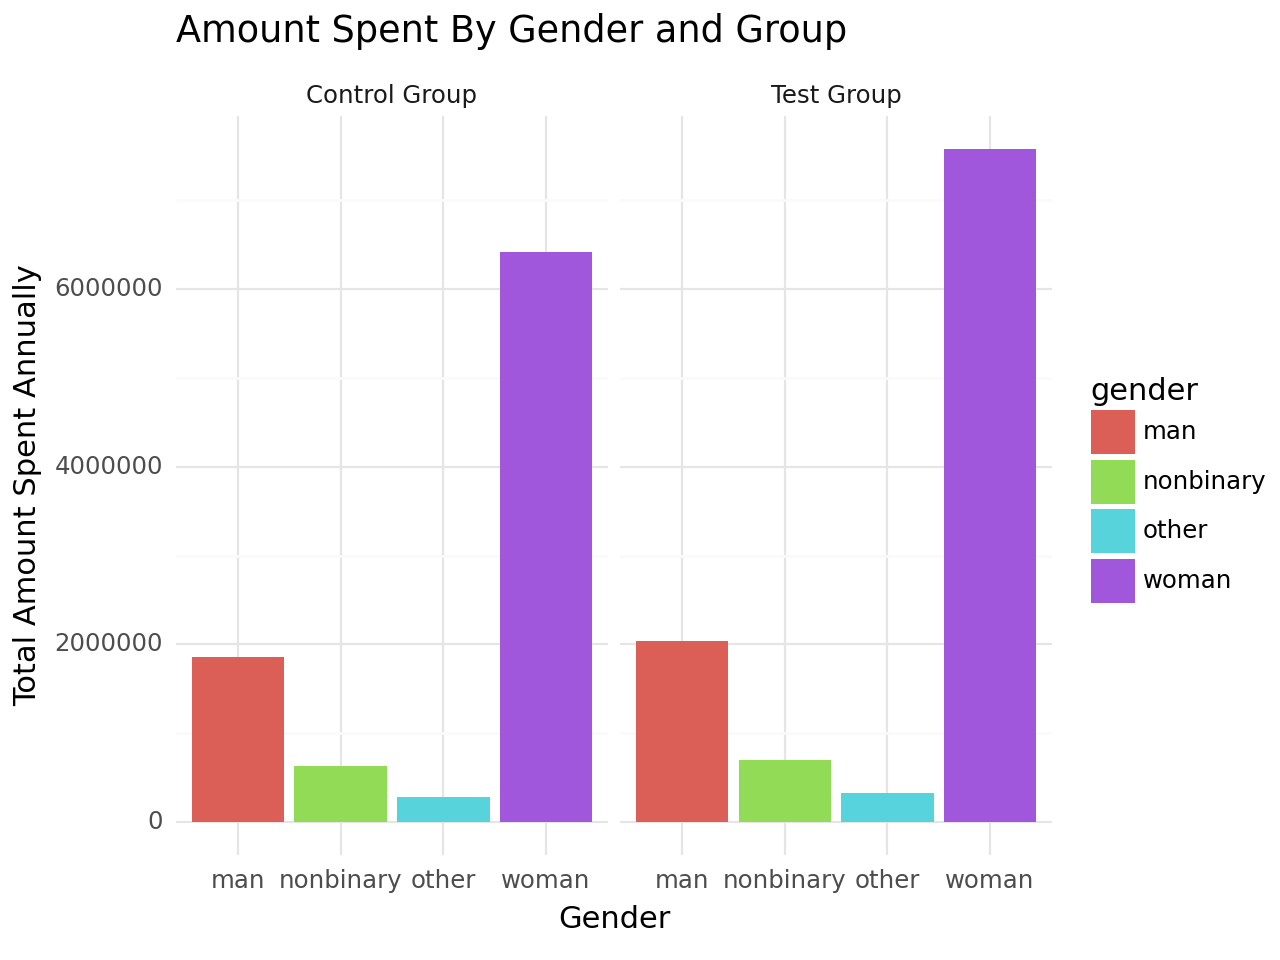

<Figure Size: (640 x 480)>

In [22]:
facet_labels = {'0': 'Control Group', '1': 'Test Group'}

(ggplot(c, aes(x = "gender", y = "amount_spent_annual", fill = "gender")) +
geom_bar(stat = "identity") + theme_minimal() +
ggtitle("Amount Spent By Gender and Group") +
labs(x = "Gender", y = "Total Amount Spent Annually") +
facet_wrap('test_group', labeller=labeller(test_group=lambda x: facet_labels[str(x)])))

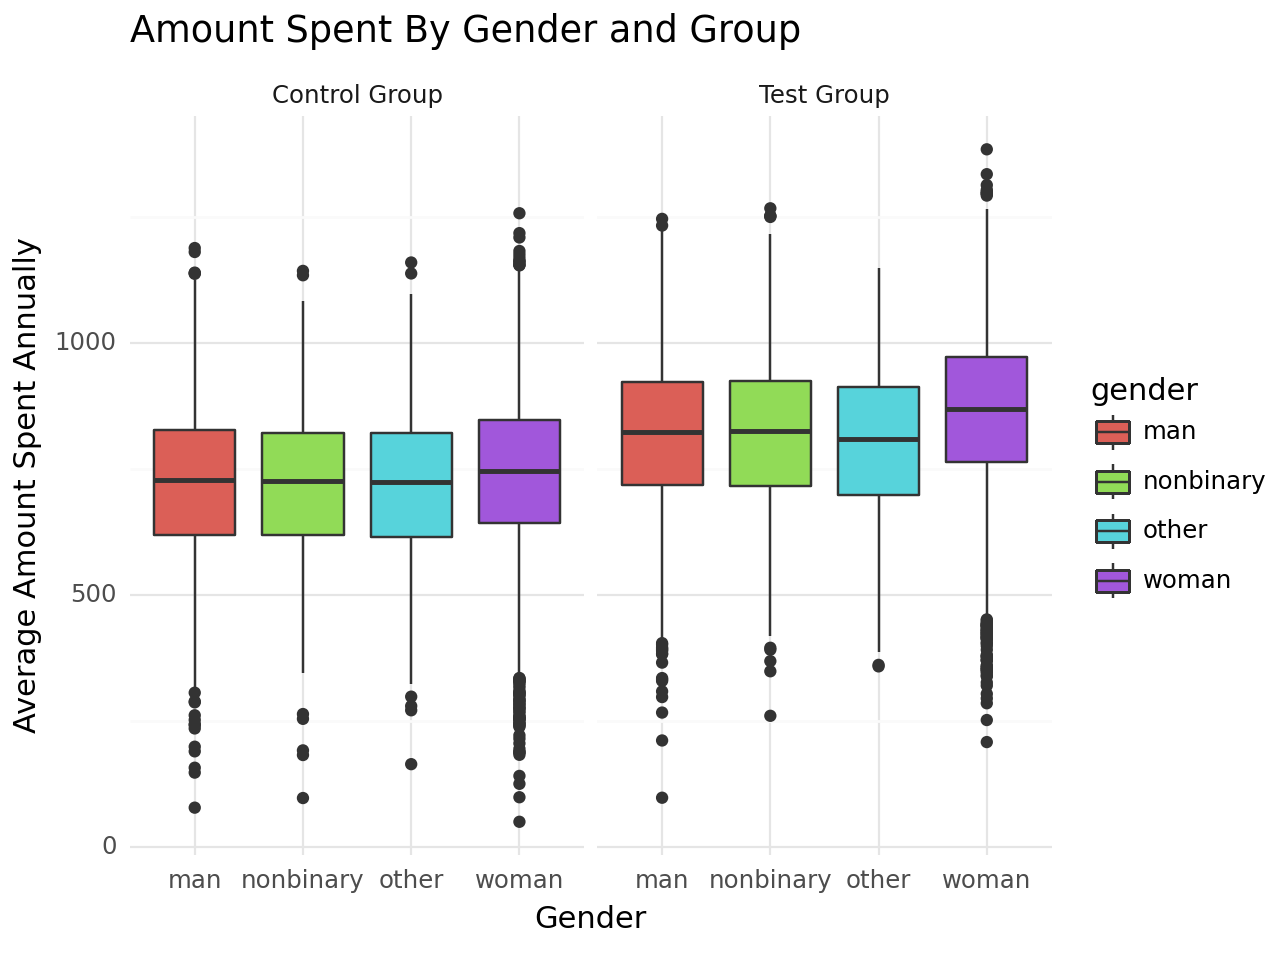

<Figure Size: (640 x 480)>

In [23]:
facet_labels = {'0': 'Control Group', '1': 'Test Group'}

(ggplot(c, aes(x = "gender", y = "amount_spent_annual", fill = "gender")) +
geom_boxplot() + theme_minimal() +
ggtitle("Amount Spent By Gender and Group") +
labs(x = "Gender", y = "Average Amount Spent Annually") +
facet_wrap('test_group', labeller=labeller(test_group=lambda x: facet_labels[str(x)])))

In which year did the store's customers make the most money? Were the store's sales highest in those years?


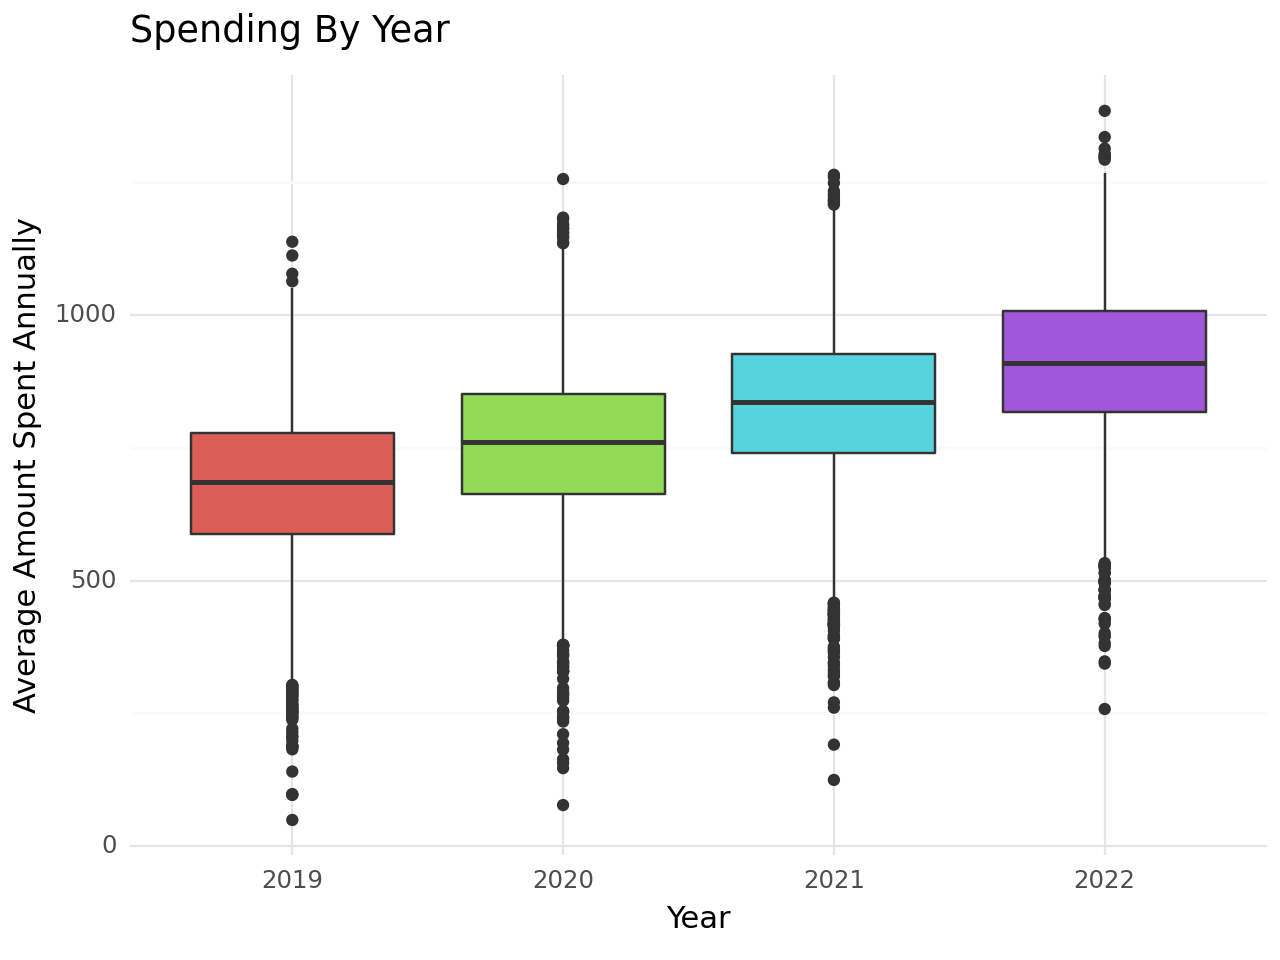

<Figure Size: (640 x 480)>

In [24]:
(ggplot(c, aes(x = "factor(year)", y = "amount_spent_annual", fill = "factor(year)")) +
geom_boxplot() + theme_minimal() +
labs(x = "Year", y = "Average Amount Spent Annually") +
ggtitle("Spending By Year") +
theme(legend_position="none"))


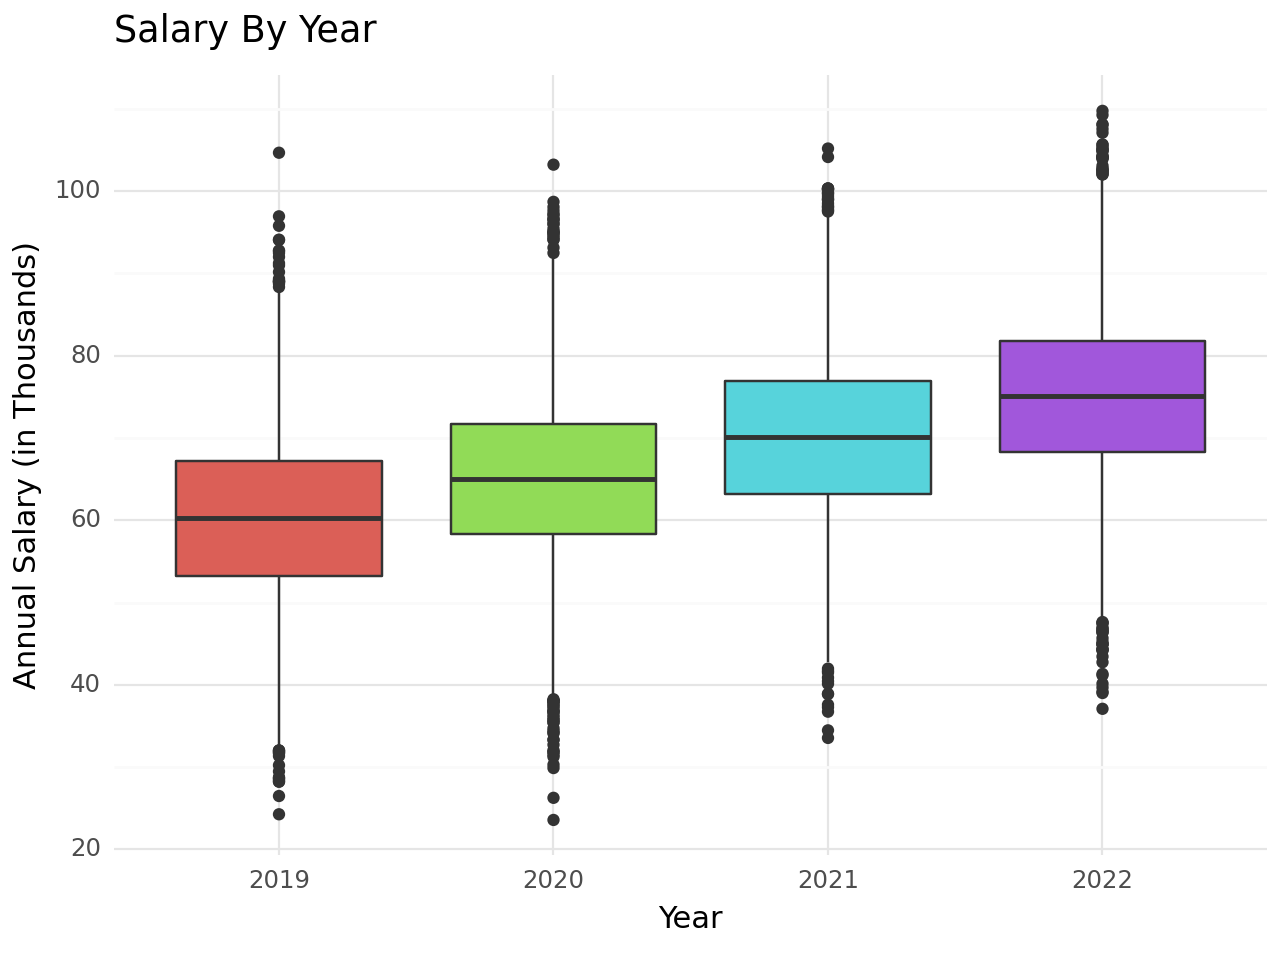

<Figure Size: (640 x 480)>

In [17]:
(ggplot(c, aes(x = "factor(year)", y = "salary_self_report_in_k", fill = "factor(year)")) +
geom_boxplot() + theme_minimal() +
labs(x = "Year", y = "Annual Salary (in Thousands)") +
ggtitle("Salary By Year") +
theme(legend_position="none"))
